# Q1

## Part A

Files already downloaded and verified
Files already downloaded and verified


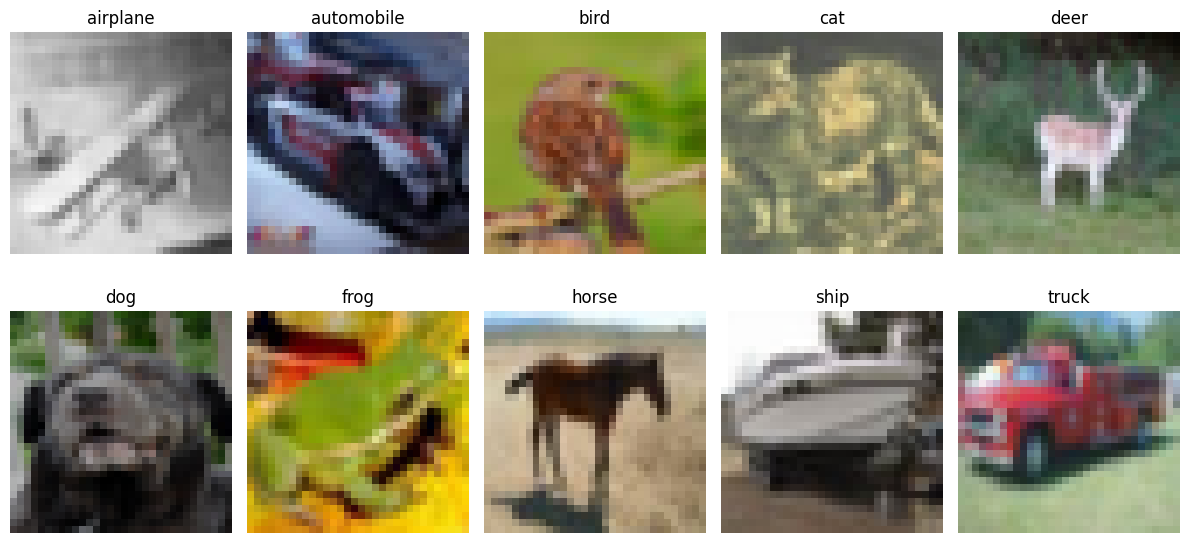

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import numpy as np


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Download CIFAR10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train dataset
train_size = 40000
val_size = 10000
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Data loaders for train, validation, and test datasets
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Display one random image from each class in the dataset
classes = train_dataset.dataset.classes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

shown_classes = set()
for image, label in train_dataset:
    if label not in shown_classes:
        shown_classes.add(label)
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        ax = axes[label]
        ax.imshow(np.transpose(np_image, (1, 2, 0)))
        ax.set_title(classes[label])
        ax.axis('off')
    if len(shown_classes) == len(classes):
        break

plt.tight_layout()
plt.show()


## Part B

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the base model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch [1/30], Train Loss: 1.7662, Train Acc: 0.3857, Val Loss: 1.5791, Val Acc: 0.4612
Epoch [2/30], Train Loss: 1.4726, Train Acc: 0.4874, Val Loss: 1.4245, Val Acc: 0.5052
Epoch [3/30], Train Loss: 1.3453, Train Acc: 0.5322, Val Loss: 1.3428, Val Acc: 0.5284
Epoch [4/30], Train Loss: 1.2731, Train Acc: 0.5581, Val Loss: 1.2885, Val Acc: 0.5539
Epoch [5/30], Train Loss: 1.2215, Train Acc: 0.5760, Val Loss: 1.2504, Val Acc: 0.5667
Epoch [6/30], Train Loss: 1.1767, Train Acc: 0.5919, Val Loss: 1.2323, Val Acc: 0.5711
Epoch [7/30], Train Loss: 1.1379, Train Acc: 0.6073, Val Loss: 1.2094, Val Acc: 0.5778
Epoch [8/30], Train Loss: 1.1015, Train Acc: 0.6190, Val Loss: 1.1798, Val Acc: 0.5916
Epoch [9/30], Train Loss: 1.0690, Train Acc: 0.6306, Val Loss: 1.1487, Val Acc: 0.6016
Epoch [10/30], Train Loss: 1.0403, Train Acc: 0.6421, Val Loss: 1.1313, Val Acc: 0.6086
Epoch [11/30], Train Loss: 1.0145, Train Acc: 0.6520, Val Loss: 1.1108, Val Acc: 0.6147
Epoch [12/30], Train Loss: 0.9914, Train 

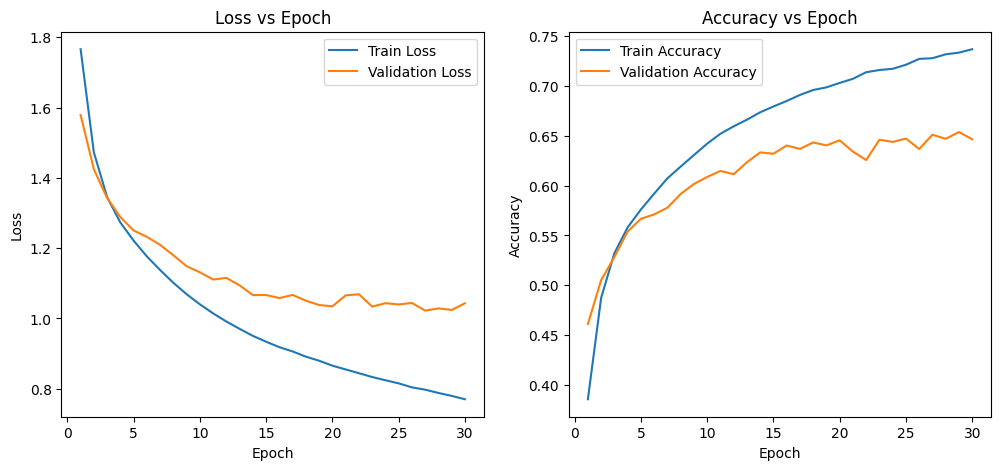

Best validation accuracy: 0.6537


In [ ]:
# Training parameters
num_epochs = 30
best_val_accuracy = 0.0
best_model_path = './best_baseline_model.pth'

# Track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

print(f"Best validation accuracy: {best_val_accuracy:.4f}")


## Part C

Enhancing the model with adding 4 convolutional layers and 3 FC layers

Epoch [1/30], Train Loss: 1.5260, Train Acc: 0.4224, Val Loss: 1.2144, Val Acc: 0.5596
Epoch [2/30], Train Loss: 1.0670, Train Acc: 0.6158, Val Loss: 0.9528, Val Acc: 0.6585
Epoch [3/30], Train Loss: 0.8356, Train Acc: 0.7038, Val Loss: 0.8287, Val Acc: 0.7050
Epoch [4/30], Train Loss: 0.6748, Train Acc: 0.7615, Val Loss: 0.7712, Val Acc: 0.7338
Epoch [5/30], Train Loss: 0.5558, Train Acc: 0.8064, Val Loss: 0.7528, Val Acc: 0.7462
Epoch [6/30], Train Loss: 0.4463, Train Acc: 0.8420, Val Loss: 0.7799, Val Acc: 0.7434
Epoch [7/30], Train Loss: 0.3560, Train Acc: 0.8741, Val Loss: 0.8255, Val Acc: 0.7452
Epoch [8/30], Train Loss: 0.2793, Train Acc: 0.9016, Val Loss: 0.9942, Val Acc: 0.7391
Epoch [9/30], Train Loss: 0.2220, Train Acc: 0.9209, Val Loss: 1.0592, Val Acc: 0.7332
Epoch [10/30], Train Loss: 0.1879, Train Acc: 0.9337, Val Loss: 1.1877, Val Acc: 0.7197
Epoch [11/30], Train Loss: 0.1607, Train Acc: 0.9445, Val Loss: 1.1139, Val Acc: 0.7484
Epoch [12/30], Train Loss: 0.1367, Train 

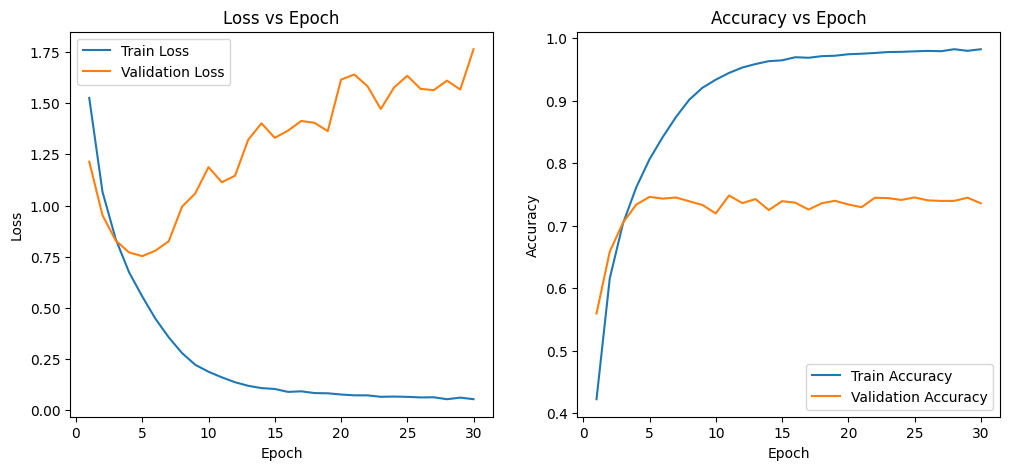

Best validation accuracy: 0.7484


In [ ]:
class EnhancedModelNoDropout(nn.Module):
    def __init__(self):
        super(EnhancedModelNoDropout, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Adjust the size according to input dimensions
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        # Flatten the tensor for FC layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

enhanced_model = EnhancedModelNoDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
best_val_accuracy = 0.0
best_model_path = './best_enhanced_model_no_dropout.pth'

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    enhanced_model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = enhanced_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    enhanced_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = enhanced_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(enhanced_model.state_dict(), best_model_path)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

print(f"Best validation accuracy: {best_val_accuracy:.4f}")


## Part D
Adding Batch Normalization layers.

Epoch [1/30], Train Loss: 1.2748, Train Acc: 0.5318, Val Loss: 1.0364, Val Acc: 0.6336
Epoch [2/30], Train Loss: 0.8526, Train Acc: 0.6979, Val Loss: 0.8116, Val Acc: 0.7168
Epoch [3/30], Train Loss: 0.6779, Train Acc: 0.7623, Val Loss: 0.7690, Val Acc: 0.7359
Epoch [4/30], Train Loss: 0.5618, Train Acc: 0.8062, Val Loss: 0.7332, Val Acc: 0.7570
Epoch [5/30], Train Loss: 0.4675, Train Acc: 0.8377, Val Loss: 0.7320, Val Acc: 0.7614
Epoch [6/30], Train Loss: 0.3808, Train Acc: 0.8667, Val Loss: 0.7534, Val Acc: 0.7617
Epoch [7/30], Train Loss: 0.3125, Train Acc: 0.8905, Val Loss: 0.7158, Val Acc: 0.7793
Epoch [8/30], Train Loss: 0.2519, Train Acc: 0.9127, Val Loss: 0.8069, Val Acc: 0.7785
Epoch [9/30], Train Loss: 0.2055, Train Acc: 0.9280, Val Loss: 0.7763, Val Acc: 0.7892
Epoch [10/30], Train Loss: 0.1661, Train Acc: 0.9413, Val Loss: 0.7932, Val Acc: 0.7872
Epoch [11/30], Train Loss: 0.1406, Train Acc: 0.9508, Val Loss: 0.8426, Val Acc: 0.7758
Epoch [12/30], Train Loss: 0.1263, Train 

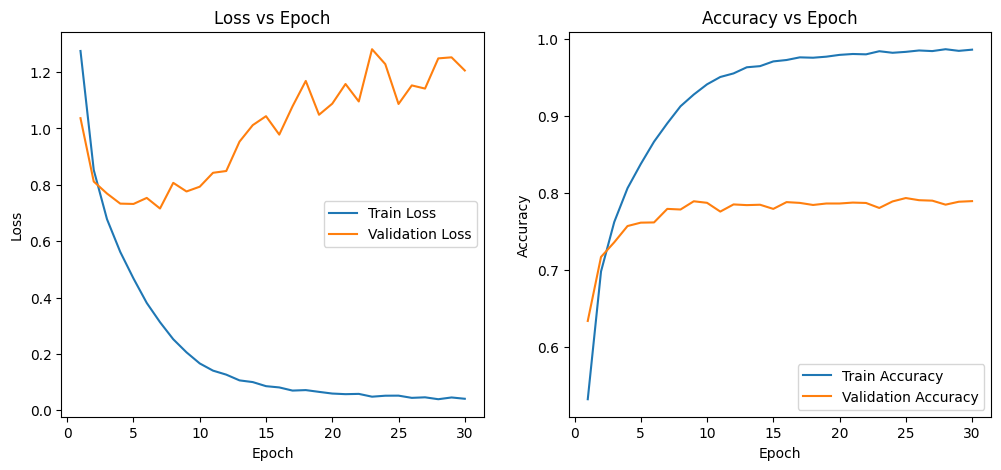

Best validation accuracy: 0.7934


In [ ]:
class EnhancedModelWithBN(nn.Module):
    def __init__(self):
        super(EnhancedModelWithBN, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Adjust the size according to input dimensions
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with Batch Normalization and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Flatten the tensor for FC layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_with_bn = EnhancedModelWithBN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_bn.parameters(), lr=0.001)

# Training loop
num_epochs = 30
best_val_accuracy = 0.0
best_model_path = './best_enhanced_model_with_bn.pth'

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model_with_bn.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_with_bn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model_with_bn.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_with_bn(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model_with_bn.state_dict(), best_model_path)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

print(f"Best validation accuracy: {best_val_accuracy:.4f}")


When we add Batch Normalization (BN) layers, accuracy often increases due to the following reasons:

1. **Internal Covariate Shift Reduction**:
   - BN normalizes the input to each layer, keeping the mean and variance stable during training.
   - This stabilization allows the network to learn faster and more effectively.

2. **Regularization Effect**:
   - BN introduces a slight regularization effect by adding noise to activations during training.
   - This reduces overfitting and improves generalization to unseen data.

3. **Smoother Optimization**:
   - BN allows the network to use higher learning rates by reducing gradient instability.
   - It smoothens the loss landscape, leading to faster convergence and better optimization.

4. **Improved Gradient Flow**:
   - BN ensures that the gradients are well-scaled throughout the network, preventing vanishing or exploding gradients.

These factors collectively lead to better model performance and higher accuracy when using Batch Normalization.

## Part E
Adding Dropout.

Epoch [1/30], Train Loss: 1.4894, Train Acc: 0.4478, Val Loss: 1.1670, Val Acc: 0.5906
Epoch [2/30], Train Loss: 1.0993, Train Acc: 0.6127, Val Loss: 0.9694, Val Acc: 0.6563
Epoch [3/30], Train Loss: 0.9220, Train Acc: 0.6810, Val Loss: 0.9197, Val Acc: 0.6758
Epoch [4/30], Train Loss: 0.7996, Train Acc: 0.7293, Val Loss: 0.7791, Val Acc: 0.7370
Epoch [5/30], Train Loss: 0.7038, Train Acc: 0.7639, Val Loss: 0.7513, Val Acc: 0.7480
Epoch [6/30], Train Loss: 0.6196, Train Acc: 0.7918, Val Loss: 0.6770, Val Acc: 0.7709
Epoch [7/30], Train Loss: 0.5465, Train Acc: 0.8168, Val Loss: 0.7622, Val Acc: 0.7519
Epoch [8/30], Train Loss: 0.4876, Train Acc: 0.8363, Val Loss: 0.7446, Val Acc: 0.7661
Epoch [9/30], Train Loss: 0.4196, Train Acc: 0.8578, Val Loss: 0.6864, Val Acc: 0.7798
Epoch [10/30], Train Loss: 0.3718, Train Acc: 0.8767, Val Loss: 0.7387, Val Acc: 0.7755
Epoch [11/30], Train Loss: 0.3240, Train Acc: 0.8922, Val Loss: 0.6951, Val Acc: 0.7929
Epoch [12/30], Train Loss: 0.2838, Train 

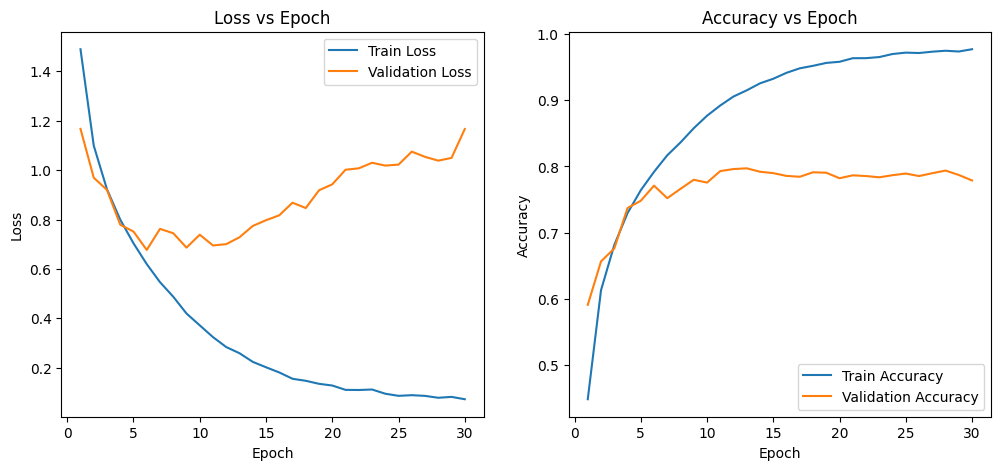

Best validation accuracy: 0.7971


In [ ]:
class EnhancedModelWithBNAndDropout(nn.Module):
    def __init__(self):
        super(EnhancedModelWithBNAndDropout, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 10)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with Batch Normalization and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Flatten the tensor for FC layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with Dropout
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model_with_bn_dropout = EnhancedModelWithBNAndDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_bn_dropout.parameters(), lr=0.001)

# Training loop
num_epochs = 30
best_val_accuracy = 0.0
best_model_path = './best_enhanced_model_with_bn_dropout.pth'

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model_with_bn_dropout.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_with_bn_dropout(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model_with_bn_dropout.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_with_bn_dropout(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model_with_bn_dropout.state_dict(), best_model_path)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

print(f"Best validation accuracy: {best_val_accuracy:.4f}")


When Dropout is added to a model, accuracy often improves due to the following reasons:

1. **Reduced Overfitting**:
   - Dropout randomly disables a fraction of neurons during training, preventing the model from relying too heavily on specific neurons or patterns.
   - This forces the network to learn more generalized and robust features.

2. **Ensemble Effect**:
   - By dropping different neurons in each iteration, Dropout effectively trains multiple sub-networks.
   - During inference, all neurons are active, simulating an ensemble of these sub-networks, which improves overall performance.

3. **Regularization**:
   - Dropout acts as a form of regularization by introducing noise in the training process, which discourages overly complex co-adaptations of neurons.

## Part F
Test best model of each step on test data.

Evaluating model: baseline


<ipython-input-9-50b72a483940>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.6540


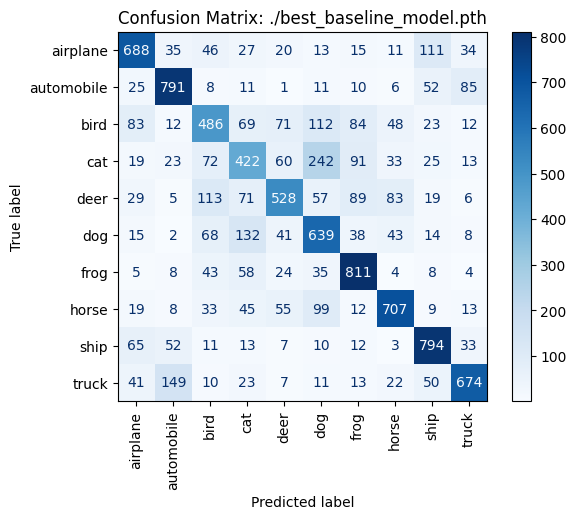

Evaluating model: enhanced


<ipython-input-9-50b72a483940>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.7512


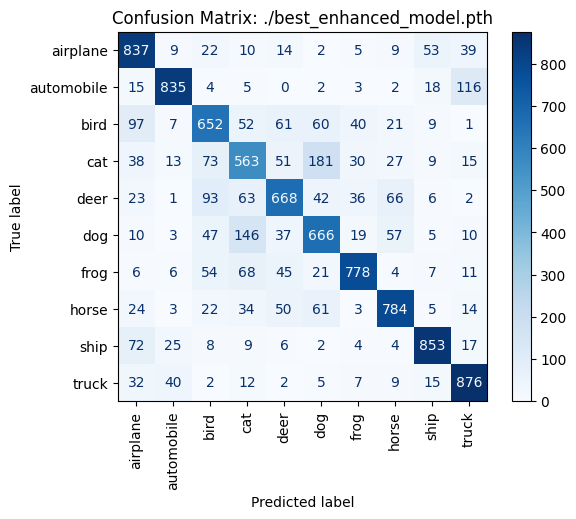

Evaluating model: enhanced_bn


<ipython-input-9-50b72a483940>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.7894


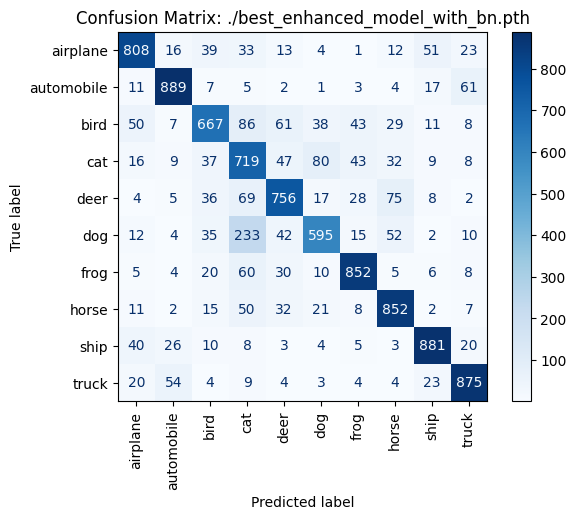

Evaluating model: enhanced_bn_dropout


<ipython-input-9-50b72a483940>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.7935


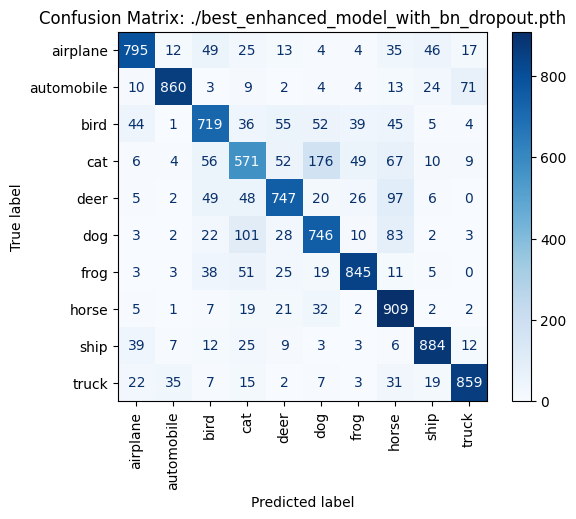


Test Accuracies:
baseline: 0.6540
enhanced: 0.7512
enhanced_bn: 0.7894
enhanced_bn_dropout: 0.7935


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load the best model for each section and evaluate on test data
def evaluate_model(model_path, model_class, test_loader, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    cm_display.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix: {model_path}")
    plt.show()

    return accuracy

# Paths to the saved models
model_paths = {
    "baseline": "./best_baseline_model.pth",
    "enhanced": "./best_enhanced_model.pth",
    "enhanced_bn": "./best_enhanced_model_with_bn.pth",
    "enhanced_bn_dropout": "./best_enhanced_model_with_bn_dropout.pth"
}

# Model classes for each section
model_classes = {
    "baseline": BaselineModel,
    "enhanced": EnhancedModel,
    "enhanced_bn": EnhancedModelWithBN,
    "enhanced_bn_dropout": EnhancedModelWithBNAndDropout
}

# Evaluate each model on the test dataset
test_accuracies = {}
for key in model_paths:
    print(f"Evaluating model: {key}")
    test_accuracy = evaluate_model(model_paths[key], model_classes[key], test_loader, device)
    test_accuracies[key] = test_accuracy

# Print the test accuracies for comparison
print("\nTest Accuracies:")
for key, acc in test_accuracies.items():
    print(f"{key}: {acc:.4f}")



## **Test Results Summary**

| Model                           | Test Accuracy | Improvement Over Baseline |
|---------------------------------|---------------|---------------------------|
| **Baseline Model**              | 65.40%        | -                         |
| **Enhanced Model**              | 75.12%        | +9.72%                    |
| **Enhanced Model with BN**      | 78.94%        | +13.54%                   |
| **Enhanced Model with BN + Dropout** | 79.35%   | +13.95%                   |

---

## **Analysis**

### 1. **Baseline Model**
- **Accuracy**: **65.40%**
- **Strengths**: Handles simpler classes like "automobile" and "truck" well due to straightforward features.
- **Weaknesses**: Struggles significantly with complex and visually similar classes like "bird," "cat," and "dog."
- **Explanation**: The model's simplicity limits its ability to learn nuanced features from the dataset.

---

### 2. **Enhanced Model (More Convolutional Layers)**
- **Accuracy**: **75.12%**
- **Improvement**: +9.72% compared to baseline.
- **Strengths**:
  - Additional convolutional layers allow the model to capture more complex and hierarchical features.
  - Better performance in challenging classes like "cat" and "bird."
- **Weaknesses**:
  - Still shows confusion between certain similar classes (e.g., "cat" and "dog").
- **Explanation**: Increased depth improves feature extraction, but the model might still overfit on training data due to lack of normalization or regularization.

---

### 3. **Enhanced Model with Batch Normalization (BN)**
- **Accuracy**: **78.94%**
- **Improvement**: +3.82% compared to the enhanced model.
- **Strengths**:
  - Significant improvement in learning stability and convergence.
  - Reduced confusion in most challenging classes (e.g., "cat" and "dog").
- **Weaknesses**:
  - Minor misclassifications persist in some classes, such as "bird" and "deer."
- **Explanation**: Batch Normalization helps normalize layer inputs, stabilizing learning and allowing the network to use higher learning rates. It also introduces a slight regularization effect, improving generalization.

---

### 4. **Enhanced Model with BN + Dropout**
- **Accuracy**: **79.35%**
- **Improvement**: +0.41% compared to the model with BN only.
- **Strengths**:
  - Marginal improvement in generalization due to the regularizing effect of Dropout.
  - Classes like "frog," "horse," and "truck" see better results compared to the previous models.
- **Weaknesses**:
  - The improvement is marginal, suggesting the BN already provided significant regularization.
- **Explanation**: Dropout in the fully connected layers further prevents overfitting by randomly dropping neurons, forcing the model to generalize better. However, its impact is limited when Batch Normalization is already applied.

---

## **Confusion Matrix Observations**
1. **Baseline Model**:
   - Higher confusion in harder classes like "bird" and "cat."
   - Handles simpler classes like "automobile" and "truck" relatively well.

2. **Enhanced Model**:
   - Noticeable reduction in confusion for most challenging classes (e.g., "bird," "cat," and "dog").
   - Improved performance across all classes.

3. **Enhanced Model with BN**:
   - Significant reduction in confusion across almost all classes.
   - Handles harder classes (e.g., "cat" and "dog") much better than previous models.

4. **Enhanced Model with BN + Dropout**:
   - Further slight reduction in confusion for some classes (e.g., "frog" and "horse").
   - Maintains consistent performance across all classes, with the highest accuracy.

---

## **Conclusion**
1. **Best Model**: The **Enhanced Model with BN + Dropout** achieves the best test accuracy (79.35%) with reduced confusion across all classes.
2. **Key Insights**:
   - Adding more convolutional layers significantly improves feature extraction.
   - Batch Normalization plays a critical role in stabilizing training and improving generalization, providing the most significant accuracy boost.
   - Dropout adds additional regularization but has a limited impact when Batch Normalization is already applied.
   
---
